In [1]:
import sys,os
sys.path.append('../')
# os.environ['LD_LIBRARY_PATH']='/home/aub3/Desktop/cuda/lib64/'

In [2]:
import argparse
import os
# import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [3]:
from dvalib.yolo.keras_yolo import preprocess_true_boxes, yolo_body,yolo_eval, yolo_head, yolo_loss
anchors_path = "model_data/yolo_anchors.txt"

In [4]:
data = np.load('/home/aub3/Desktop/underwater_data.npz')

In [5]:
YOLO_ANCHORS = np.array(((0.57273, 0.677385), (1.87446, 2.06253), (3.33843, 5.47434),(7.88282, 3.52778), (9.77052, 9.16828)))
class_names = ["red_buoy","green_buoy","yellow_buoy","path_marker","start_gate","channel"]
# anchors = np.array([float(x) for x in file(anchors_path).readline().split(',')]).reshape(-1, 2)
anchors = YOLO_ANCHORS

In [6]:
def get_detector_mask(boxes, anchors):
    '''
    Precompute detectors_mask and matching_true_boxes for training.
    Detectors mask is 1 for each spatial position in the final conv layer and
    anchor that should be active for the given boxes and 0 otherwise.
    Matching true boxes gives the regression targets for the ground truth box
    that caused a detector to be active or 0 otherwise.
    '''
    detectors_mask = [0 for i in range(len(boxes))]
    matching_true_boxes = [0 for i in range(len(boxes))]
    for i, box in enumerate(boxes):
        detectors_mask[i], matching_true_boxes[i] = preprocess_true_boxes(box, anchors, [416, 416])

    return np.array(detectors_mask), np.array(matching_true_boxes)

In [7]:
def process_data(images, boxes):
    images = [PIL.Image.fromarray(i) for i in images]
    orig_size = np.array([float(images[0].width), float(images[0].height)])
    orig_size = np.expand_dims(orig_size, axis=0)
    print orig_size
    processed_images = [i.resize((416, 416), PIL.Image.BICUBIC) for i in images]
    processed_images = [np.array(image, dtype=np.float) for image in processed_images]
    processed_images = [image/255. for image in processed_images]
    boxes = [box.reshape((-1, 5)) for box in boxes]
    boxes_extents = [box[:, [2, 1, 4, 3, 0]] for box in boxes]
    boxes_xy = [0.5 * (box[:, 3:5] + box[:, 1:3]) for box in boxes]
    boxes_wh = [box[:, 3:5] - box[:, 1:3] for box in boxes]
    print boxes_wh[0]
    boxes_xy = [boxxy / orig_size for boxxy in boxes_xy]
    boxes_wh = [boxwh / orig_size for boxwh in boxes_wh]
    print "width,height",boxes_wh[0]
    boxes = [np.concatenate((boxes_xy[i], boxes_wh[i], box[:, 0:1]), axis=1) for i, box in enumerate(boxes)]
    max_boxes = 0
    for boxz in boxes:
        if boxz.shape[0] > max_boxes:
            max_boxes = boxz.shape[0]
    print "max_boxes",max_boxes
    for i, boxz in enumerate(boxes):
        if boxz.shape[0]  < max_boxes:
            zero_padding = np.zeros( (max_boxes-boxz.shape[0], 5), dtype=np.float32)
            boxes[i] = np.vstack((boxz, zero_padding))
    return np.array(processed_images), np.array(boxes)

In [8]:
print len(data['images'])
print data['boxes'][10]
image_data, boxes = process_data(data['images'][:1000], data['boxes'][:1000])
print len(image_data),len(boxes)
print boxes[10].shape
print boxes[10]

629
[[  4   6  38 629 372]]
[[ 640.  480.]]
[[602 310]]
width,height [[ 0.940625    0.64583333]]
max_boxes 6
629 629
(6, 5)
[[ 0.49609375  0.42708333  0.9734375   0.69583333  4.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]


In [9]:
detectors_mask, matching_true_boxes = get_detector_mask(boxes, anchors)

In [10]:
detectors_mask[10].max()

1.0

In [11]:
print detectors_mask.shape
print matching_true_boxes.shape

(629, 13, 13, 5, 1)
(629, 13, 13, 5, 5)


In [12]:
def create_model(anchors, class_names, load_pretrained=True, freeze_body=True):
    '''
    returns the body of the model and the model
    load_pretrained: whether or not to load the pretrained model or initialize all weights
    freeze_body: whether or not to freeze all weights except for the last layer's
    model_body: YOLOv2 with new output layer
    model: YOLOv2 with custom loss Lambda layer
    '''
    detectors_mask_shape = (13, 13, 5, 1)
    matching_boxes_shape = (13, 13, 5, 5)

    # Create model input layers.
    image_input = Input(shape=(416, 416, 3))
    boxes_input = Input(shape=(None, 5))
    detectors_mask_input = Input(shape=detectors_mask_shape)
    matching_boxes_input = Input(shape=matching_boxes_shape)

    # Create model body.
    yolo_model = yolo_body(image_input, len(anchors), len(class_names))
    topless_yolo = Model(yolo_model.input, yolo_model.layers[-2].output)

    if load_pretrained:
        # Save topless yolo:
        topless_yolo_path = os.path.join('/home/aub3/repos/DeepVideoAnalytics/dvalib/yolo/model_data/', 'yolo_topless.h5')
        if not os.path.exists(topless_yolo_path):
            print("CREATING TOPLESS WEIGHTS FILE")
            yolo_path = '/home/aub3/repos/DeepVideoAnalytics/dvalib/yolo/model_data/yolo.h5'
            model_body = load_model(yolo_path)
            model_body = Model(model_body.inputs, model_body.layers[-2].output)
            model_body.save_weights(topless_yolo_path)
        topless_yolo.load_weights(topless_yolo_path)

    if freeze_body:
        for layer in topless_yolo.layers:
            layer.trainable = False
    else:
        for layer in topless_yolo.layers[:8]:
            print layer
            layer.trainable = False

    final_layer = Conv2D(len(anchors)*(5+len(class_names)), (1, 1), activation='linear')(topless_yolo.output)

    model_body = Model(image_input, final_layer)

    # Place model loss on CPU to reduce GPU memory usage.
    with tf.device('/cpu:0'):
        # TODO: Replace Lambda with custom Keras layer for loss.
        model_loss = Lambda(
            yolo_loss,
            output_shape=(1, ),
            name='yolo_loss',
            arguments={'anchors': anchors,
                       'num_classes': len(class_names)})([
                           model_body.output, boxes_input,
                           detectors_mask_input, matching_boxes_input
                       ])

    model = Model(
        [model_body.input, boxes_input, detectors_mask_input,
         matching_boxes_input], model_loss)

    return model_body, model

In [13]:
model_body, model = create_model(anchors, class_names)

CREATING TOPLESS WEIGHTS FILE


/home/aub3/chenv/local/lib/python2.7/site-packages/keras/models.py:248: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
def train(model, class_names, anchors, image_data, boxes, detectors_mask, matching_true_boxes, validation_split=0.1):
    '''
    retrain/fine-tune the model

    logs training with tensorboard

    saves training weights in current directory

    best weights according to val_loss is saved as trained_stage_3_best.h5
    '''
    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


    logging = TensorBoard()
    checkpoint = ModelCheckpoint("trained_stage_3_best.h5", monitor='val_loss',
                                 save_weights_only=True, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

    model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(image_data)),
              validation_split=validation_split,
              batch_size=32,
              epochs=20,
              callbacks=[logging])
    model.save_weights('trained_stage_1.h5')

    model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)

    model.load_weights('trained_stage_1.h5')

    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


    model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(image_data)),
              validation_split=0.1,
              batch_size=8,
              epochs=50,
              callbacks=[logging, checkpoint, early_stopping])

    model.save_weights('trained_stage_3.h5')

In [15]:
train(model,class_names,anchors,image_data,boxes,detectors_mask,matching_true_boxes)

Train on 566 samples, validate on 63 samples
Epoch 1/20
566/566 [==============================] - 23s - loss: 1144.6710 - val_loss: 250.9467
Epoch 2/20
566/566 [==============================] - 17s - loss: 253.1675 - val_loss: 224.4819
Epoch 3/20
566/566 [==============================] - 17s - loss: 222.9528 - val_loss: 217.5855
Epoch 4/20
566/566 [==============================] - 17s - loss: 207.7558 - val_loss: 204.7712
Epoch 5/20
566/566 [==============================] - 17s - loss: 193.9409 - val_loss: 186.4767
Epoch 6/20
566/566 [==============================] - 17s - loss: 182.1428 - val_loss: 175.7602
Epoch 7/20
566/566 [==============================] - 17s - loss: 173.9222 - val_loss: 169.4286
Epoch 8/20
566/566 [==============================] - 17s - loss: 166.5463 - val_loss: 163.4555
Epoch 9/20
566/566 [==============================] - 17s - loss: 162.0638 - val_loss: 159.6469
Epoch 10/20
566/566 [==============================] - 17s - loss: 157.6460 - val_loss: 15

In [16]:
import dvalib.yolo.draw_boxes as draw_boxes

In [17]:
reload(draw_boxes)

<module 'dvalib.yolo.draw_boxes' from '../dvalib/yolo/draw_boxes.pyc'>

In [18]:
import matplotlib.pyplot as plt

In [19]:
def draw(model_body, class_names, anchors, image_data, image_set='val',
            weights_name='trained_stage_3_best.h5', out_path="output_images", save_all=True):
    '''
    Draw bounding boxes on image data
    '''
    if image_set == 'train':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data[:int(len(image_data)*.9)]])
    elif image_set == 'val':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data[int(len(image_data)*.9):]])
    elif image_set == 'all':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data])
    else:
        ValueError("draw argument image_set must be 'train', 'val', or 'all'")
    # model.load_weights(weights_name)
    print(image_data.shape)
    model_body.load_weights(weights_name)

    # Create output variables for prediction.
    yolo_outputs = yolo_head(model_body.output, anchors, len(class_names))
    input_image_shape = K.placeholder(shape=(2, ))
    boxes, scores, classes = yolo_eval(
        yolo_outputs, input_image_shape, score_threshold=0.5, iou_threshold=0)

    # Run prediction on overfit image.
    sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.

    if  not os.path.exists(out_path):
        os.makedirs(out_path)
    for i in range(len(image_data)):
        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                model_body.input: image_data[i],
                input_image_shape: [image_data.shape[2], image_data.shape[3]],
                K.learning_phase(): 0
            })
        print('Found {} boxes for image.'.format(len(out_boxes)))
        print(out_boxes)

        # Plot image with predicted boxes.
        image_with_boxes = draw_boxes.draw_boxes(image_data[i][0], out_boxes, out_classes,
                                    class_names, out_scores)
        # Save the image:
        if save_all or (len(out_boxes) > 0):
            image = PIL.Image.fromarray(image_with_boxes)
            image.save(os.path.join(out_path,str(i)+'.png'))
        plt.imshow(image_with_boxes, interpolation='nearest')
        plt.show()

(63, 1, 416, 416, 3)
Found 3 boxes for image.
[[ 283.17474365   14.53257465  344.13113403   65.87771606]
 [ 212.91404724  220.82067871  268.24334717  267.42883301]
 [ 156.33985901    1.01133537  237.69192505   89.94974518]]
('red_buoy 1.00', (15, 283), (66, 344))
('green_buoy 0.98', (221, 213), (267, 268))
('channel 0.98', (1, 156), (90, 238))


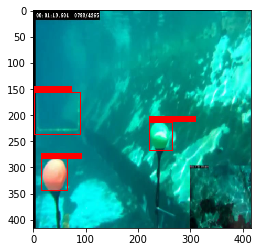

Found 2 boxes for image.
[[ 133.47538757    2.05302048  224.55024719   89.15913391]
 [ 128.20695496  223.6784668   246.27973938  344.35272217]]
('channel 0.96', (2, 133), (89, 225))
('yellow_buoy 0.70', (224, 128), (344, 246))


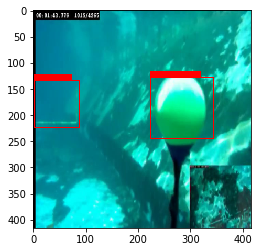

Found 2 boxes for image.
[[  3.01763153e+02   7.70514374e+01   3.77897644e+02   1.47324829e+02]
 [  1.64952278e-01   6.66363297e+01   2.18730011e+02   2.43886871e+02]]
('path_marker 0.93', (77, 302), (147, 378))
('channel 0.82', (67, 0), (244, 219))


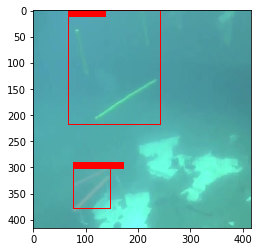

Found 2 boxes for image.
[[ 156.69033813  196.53456116  257.60836792  282.2208252 ]
 [ 155.3367157     1.66855025  234.63246155   76.0641861 ]]
('green_buoy 0.93', (197, 157), (282, 258))
('channel 0.92', (2, 155), (76, 235))


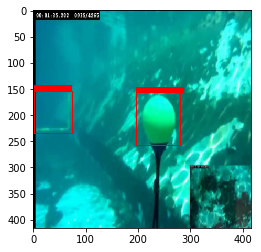

Found 1 boxes for image.
[[ 174.2550354    57.72378922  215.36026001   83.32772827]]
('green_buoy 0.99', (58, 174), (83, 215))


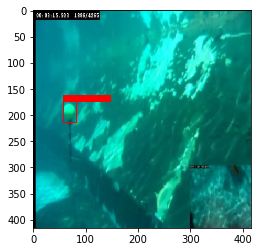

Found 3 boxes for image.
[[ 204.25427246  137.35317993  245.14425659  163.37619019]
 [ 161.35218811  266.33209229  206.61946106  291.26513672]
 [ 329.46923828  130.85710144  382.9119873   145.85707092]]
('red_buoy 0.99', (137, 204), (163, 245))
('green_buoy 0.96', (266, 161), (291, 207))
('path_marker 0.92', (131, 329), (146, 383))


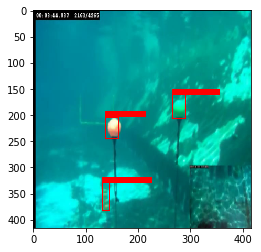

Found 1 boxes for image.
[[ 158.8886261   122.48620605  234.70280457  226.95419312]]
('channel 0.98', (122, 159), (227, 235))


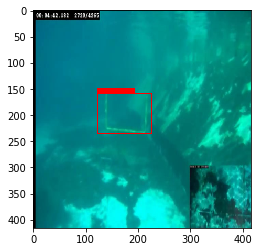

Found 3 boxes for image.
[[ 207.3094635   261.04226685  220.3412323   272.22213745]
 [ 194.02555847  305.92706299  207.58175659  319.39535522]
 [ 216.25405884  206.1567688   234.8530426   221.14881897]]
('red_buoy 1.00', (261, 207), (272, 220))
('green_buoy 1.00', (306, 194), (319, 208))
('yellow_buoy 0.97', (206, 216), (221, 235))


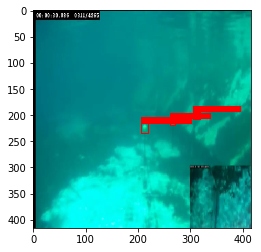

Found 3 boxes for image.
[[ 172.9284668   306.97311401  187.36810303  318.42169189]
 [ 180.55528259  275.75177002  190.90419006  284.82019043]
 [ 181.47090149  238.21566772  193.5519104   250.57955933]]
('green_buoy 0.99', (307, 173), (318, 187))
('red_buoy 0.99', (276, 181), (285, 191))
('yellow_buoy 0.98', (238, 181), (251, 194))


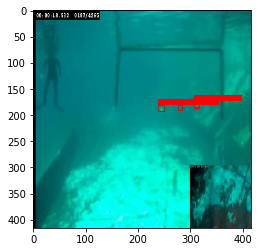

Found 1 boxes for image.
[[  85.61514282  173.79231262  144.81869507  218.06106567]]
('green_buoy 0.88', (174, 86), (218, 145))


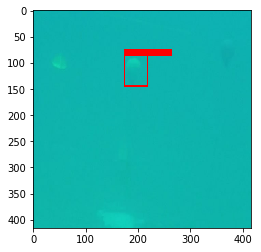

Found 1 boxes for image.
[[  46.17598724   51.79835129  324.24209595  373.11752319]]
('start_gate 0.96', (52, 46), (373, 324))


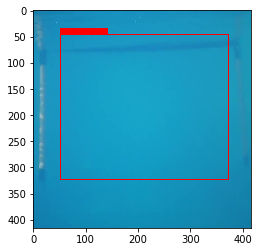

Found 2 boxes for image.
[[ 318.02139282  329.24777222  409.31283569  340.0715332 ]
 [ 103.71465302  179.5226593   254.07017517  314.35015869]]
('path_marker 0.98', (329, 318), (340, 409))
('channel 0.95', (180, 104), (314, 254))


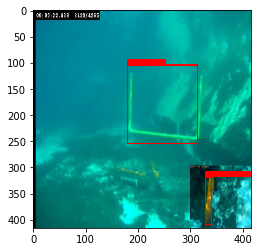

Found 1 boxes for image.
[[  34.95241547   40.91675568  332.0843811   381.4246521 ]]
('start_gate 0.96', (41, 35), (381, 332))


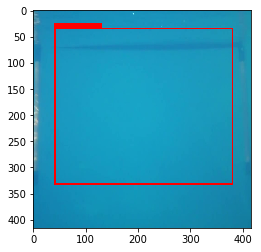

Found 1 boxes for image.
[[  14.17444038   15.17911816  468.56274414  407.25640869]]
('channel 0.97', (15, 14), (407, 416))


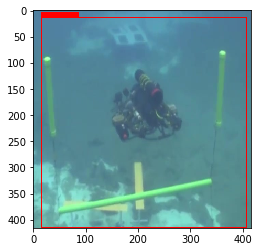

Found 3 boxes for image.
[[ 264.43374634    8.32213402  331.61560059   61.37654114]
 [ 186.12557983  224.39880371  264.20025635  274.52624512]
 [ 147.66305542    3.77680588  224.05743408  112.39665985]]
('red_buoy 1.00', (8, 264), (61, 332))
('green_buoy 0.95', (224, 186), (275, 264))
('channel 0.90', (4, 148), (112, 224))


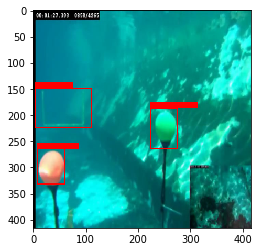

Found 1 boxes for image.
[[  93.01087189  156.2926178   217.63967896  289.59838867]]
('yellow_buoy 0.76', (156, 93), (290, 218))


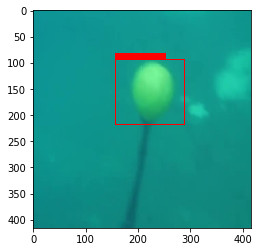

Found 1 boxes for image.
[[  23.72487259   52.06640244  338.82336426  372.51925659]]
('start_gate 0.97', (52, 24), (373, 339))


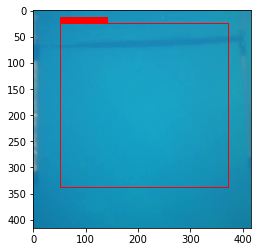

Found 1 boxes for image.
[[ 165.82792664  190.12733459  252.84596252  284.08334351]]
('start_gate 0.87', (190, 166), (284, 253))


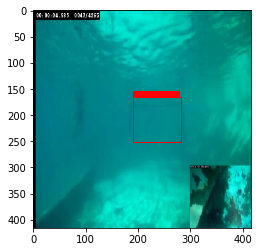

Found 4 boxes for image.
[[ 256.7276001   169.2648468   322.26403809  219.46925354]
 [ 157.69863892   23.20164108  230.73583984  126.62076569]
 [ 191.75300598  323.28646851  241.84111023  366.6489563 ]
 [ 368.43878174  108.56040955  413.55947876  128.06941223]]
('red_buoy 0.96', (169, 257), (219, 322))
('channel 0.95', (23, 158), (127, 231))
('green_buoy 0.94', (323, 192), (367, 242))
('path_marker 0.92', (109, 368), (128, 414))


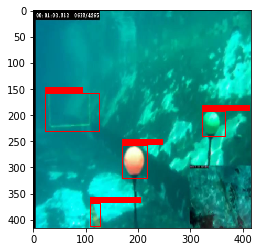

Found 5 boxes for image.
[[ 206.49563599  190.79019165  233.24740601  209.57156372]
 [ 223.400177     73.42907715  258.88223267   97.6285553 ]
 [ 180.02807617  296.75811768  215.98023987  319.87643433]
 [ 298.31103516  396.45288086  360.11767578  411.171875  ]
 [ 304.44335938  193.68136597  349.77603149  205.59431458]]
('red_buoy 1.00', (191, 206), (210, 233))
('yellow_buoy 0.99', (73, 223), (98, 259))
('green_buoy 0.99', (297, 180), (320, 216))
('path_marker 0.98', (396, 298), (411, 360))
('path_marker 0.78', (194, 304), (206, 350))


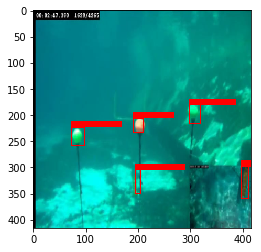

Found 1 boxes for image.
[[  16.40560532   41.8756752   337.70092773  380.3394165 ]]
('start_gate 0.98', (42, 16), (380, 338))


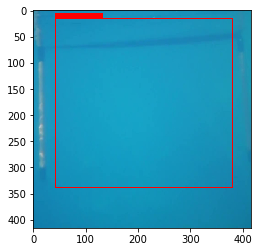

Found 5 boxes for image.
[[ 206.86950684  221.41770935  233.29095459  239.83171082]
 [ 222.23052979  103.69532013  259.7253418   127.86090088]
 [ 178.53044128  320.56622314  217.411026    345.01599121]
 [ 304.29467773  209.03669739  360.39648438  222.31674194]
 [ 297.54498291  388.61843872  357.41049194  417.86392212]]
('red_buoy 1.00', (221, 207), (240, 233))
('yellow_buoy 1.00', (104, 222), (128, 260))
('green_buoy 0.99', (321, 179), (345, 217))
('path_marker 0.94', (209, 304), (222, 360))
('path_marker 0.92', (389, 298), (416, 357))


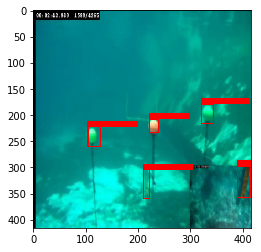

Found 5 boxes for image.
[[ 226.62226868  255.82601929  263.11453247  277.14382935]
 [ 284.74310303    6.55329657  323.57580566   14.7720623 ]
 [ 163.89070129   90.8661499   230.09490967  172.2762146 ]
 [ 258.87084961  139.52400208  295.30044556  161.74714661]
 [ 345.38647461  134.09341431  401.50250244  146.93348694]]
('green_buoy 0.99', (256, 227), (277, 263))
('yellow_buoy 0.96', (7, 285), (15, 324))
('channel 0.95', (91, 164), (172, 230))
('red_buoy 0.91', (140, 259), (162, 295))
('path_marker 0.74', (134, 345), (147, 402))


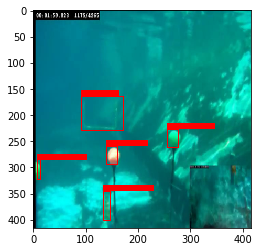

Found 1 boxes for image.
[[  -2.48644638   56.93421173  295.69747925  364.68572998]]
('start_gate 0.94', (57, 0), (365, 296))


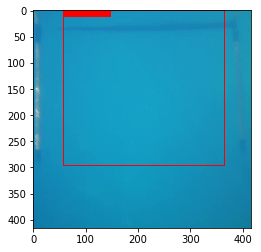

Found 4 boxes for image.
[[ 260.88467407  125.62722015  298.99557495  148.30276489]
 [ 223.88830566  253.59402466  260.98461914  278.10385132]
 [ 369.61663818  123.92245483  416.4543457   139.81832886]
 [ 178.15705872   76.51773834  246.2624054   154.86442566]]
('red_buoy 1.00', (126, 261), (148, 299))
('green_buoy 0.96', (254, 224), (278, 261))
('path_marker 0.96', (124, 370), (140, 416))
('channel 0.96', (77, 178), (155, 246))


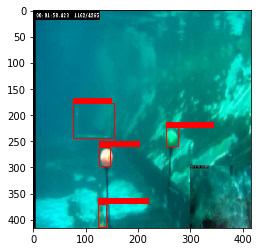

Found 5 boxes for image.
[[ 210.48899841  264.42327881  243.21405029  287.45471191]
 [ 181.8031311   367.35046387  222.54483032  393.51525879]
 [ 224.69767761  144.88900757  258.28262329  166.79316711]
 [ 299.19699097  387.13803101  363.42401123  417.81835938]
 [ 307.41326904  245.11300659  352.66864014  259.30432129]]
('red_buoy 1.00', (264, 210), (287, 243))
('green_buoy 0.99', (367, 182), (394, 223))
('yellow_buoy 0.98', (145, 225), (167, 258))
('path_marker 0.93', (387, 299), (416, 363))
('path_marker 0.81', (245, 307), (259, 353))


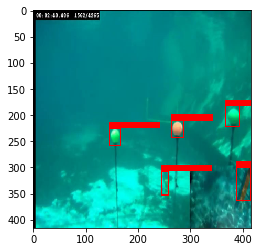

Found 1 boxes for image.
[[ 128.48576355  167.52484131  267.51678467  259.89102173]]
('red_buoy 0.90', (168, 128), (260, 268))


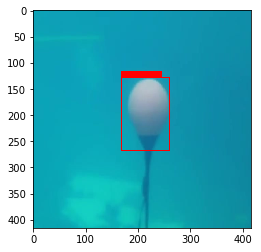

Found 2 boxes for image.
[[ 136.36732483  101.49082947  215.52772522  200.04779053]
 [ 378.51846313  162.58804321  412.27120972  178.59468079]]
('channel 0.98', (101, 136), (200, 216))
('path_marker 0.67', (163, 379), (179, 412))


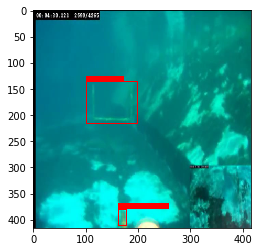

Found 1 boxes for image.
[[ 129.85662842  136.23397827  241.73957825  232.24365234]]
('yellow_buoy 0.98', (136, 130), (232, 242))


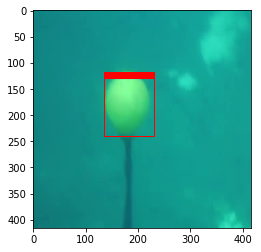

Found 3 boxes for image.
[[ 200.0243988   262.10577393  213.75973511  273.2663269 ]
 [ 191.33082581  303.5802002   207.25486755  318.12863159]
 [ 208.6905365   208.43858337  224.1962738   221.86010742]]
('red_buoy 1.00', (262, 200), (273, 214))
('green_buoy 0.99', (304, 191), (318, 207))
('yellow_buoy 0.95', (208, 209), (222, 224))


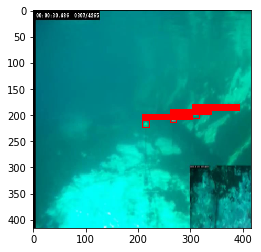

Found 3 boxes for image.
[[ 258.12661743   10.72795868  324.83236694   61.14459229]
 [ 187.22302246  226.25093079  248.32408142  276.5055542 ]
 [ 147.48617554    5.08419371  224.38818359  105.05619049]]
('red_buoy 0.99', (11, 258), (61, 325))
('green_buoy 0.97', (226, 187), (277, 248))
('channel 0.86', (5, 147), (105, 224))


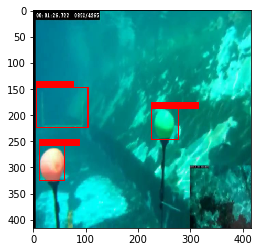

Found 1 boxes for image.
[[ 105.0705719   167.35604858  240.32392883  244.79049683]]
('yellow_buoy 0.98', (167, 105), (245, 240))


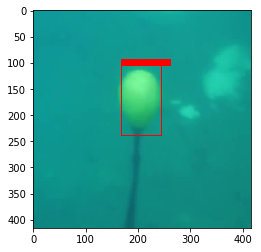

Found 3 boxes for image.
[[ 173.89849854  123.3637085   215.72537231  147.54165649]
 [ 215.71125793   10.49901009  245.15481567   35.36277008]
 [ 344.11004639   31.51870346  381.42697144   44.5031395 ]]
('green_buoy 0.99', (123, 174), (148, 216))
('red_buoy 0.95', (10, 216), (35, 245))
('path_marker 0.79', (32, 344), (45, 381))


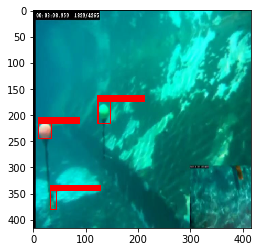

Found 1 boxes for image.
[[ 118.53851318  163.03425598  231.83782959  371.8505249 ]]
('start_gate 0.99', (163, 119), (372, 232))


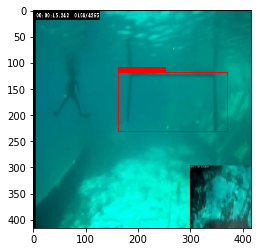

Found 2 boxes for image.
[[ 348.58270264   51.18349457  374.51422119  211.75320435]
 [ 182.00642395  270.47067261  213.78915405  290.58810425]]
('path_marker 0.96', (51, 349), (212, 375))
('green_buoy 0.52', (270, 182), (291, 214))


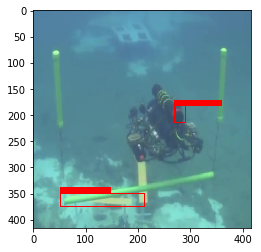

Found 4 boxes for image.
[[ 132.54656982  114.59147644  202.65306091  180.34223938]
 [ 152.25860596  290.26400757  180.72094727  310.43035889]
 [ 185.07275391  221.20890808  210.18725586  237.97351074]
 [ 211.19163513  126.03652191  239.2923584   143.40681458]]
('channel 0.98', (115, 133), (180, 203))
('green_buoy 0.98', (290, 152), (310, 181))
('red_buoy 0.98', (221, 185), (238, 210))
('yellow_buoy 0.97', (126, 211), (143, 239))


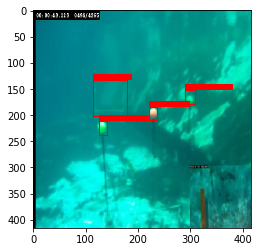

Found 1 boxes for image.
[[  86.72817993   68.37976837  391.46005249  349.95150757]]
('start_gate 0.98', (68, 87), (350, 391))


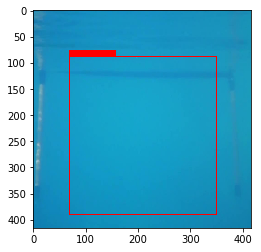

Found 3 boxes for image.
[[ 280.4213562    46.61923599  341.96554565   97.03700256]
 [ 206.49501038  247.34022522  255.9034729   286.27050781]
 [ 155.30230713    1.60071278  236.99136353   90.75698853]]
('red_buoy 1.00', (47, 280), (97, 342))
('green_buoy 0.97', (247, 206), (286, 256))
('channel 0.94', (2, 155), (91, 237))


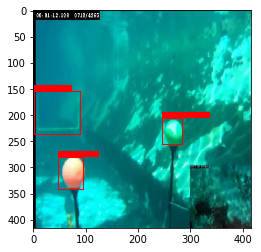

Found 5 boxes for image.
[[ 213.61177063  202.55381775  242.04878235  224.28738403]
 [ 190.68344116  302.86209106  229.40663147  324.06903076]
 [ 231.80447388   92.67196655  259.6368103   111.53923035]
 [ 300.95553589  193.09890747  362.07687378  205.72134399]
 [ 305.64950562  390.25357056  353.26266479  404.46914673]]
('red_buoy 1.00', (203, 214), (224, 242))
('green_buoy 0.99', (303, 191), (324, 229))
('yellow_buoy 0.98', (93, 232), (112, 260))
('path_marker 0.92', (193, 301), (206, 362))
('path_marker 0.56', (390, 306), (404, 353))


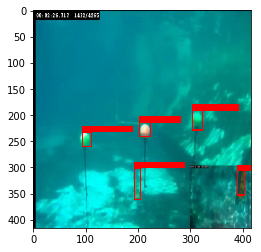

Found 3 boxes for image.
[[ 212.36238098  357.51937866  247.78973389  379.70339966]
 [ 223.04125977  235.22941589  255.45895386  257.42672729]
 [ 313.34295654  383.2510376   380.56536865  417.61380005]]
('red_buoy 0.99', (358, 212), (380, 248))
('yellow_buoy 0.98', (235, 223), (257, 255))
('path_marker 0.93', (383, 313), (416, 381))


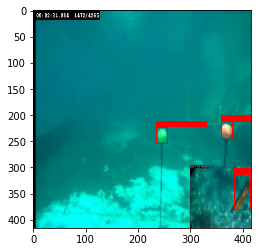

Found 3 boxes for image.
[[ 279.06665039  109.63526917  340.64901733  160.21507263]
 [ 201.37492371  286.519104    255.82447815  332.34063721]
 [ 161.8634491     1.79881668  239.06468201   98.28484344]]
('red_buoy 1.00', (110, 279), (160, 341))
('green_buoy 0.97', (287, 201), (332, 256))
('channel 0.97', (2, 162), (98, 239))


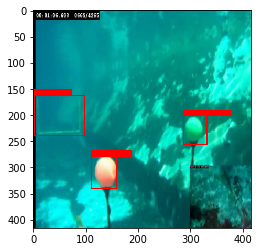

Found 3 boxes for image.
[[ 213.33441162   44.8584137   240.32852173   70.4441452 ]
 [ 173.63766479  157.02113342  214.08633423  178.17581177]
 [ 292.55288696  386.28787231  325.40606689  402.05252075]]
('red_buoy 0.98', (45, 213), (70, 240))
('green_buoy 0.98', (157, 174), (178, 214))
('path_marker 0.94', (386, 293), (402, 325))


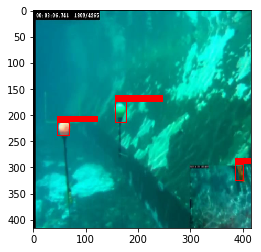

Found 3 boxes for image.
[[ 171.41603088  305.98681641  185.49835205  317.22518921]
 [ 180.05673218  276.38934326  189.87290955  285.24615479]
 [ 181.60049438  238.10101318  193.55511475  250.27159119]]
('green_buoy 0.99', (306, 171), (317, 185))
('red_buoy 0.99', (276, 180), (285, 190))
('yellow_buoy 0.98', (238, 182), (250, 194))


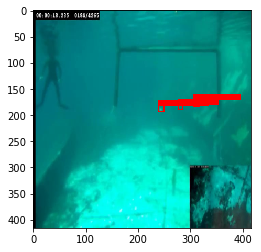

Found 1 boxes for image.
[[  85.14517212  186.49642944  185.92677307  338.64657593]]
('start_gate 0.88', (186, 85), (339, 186))


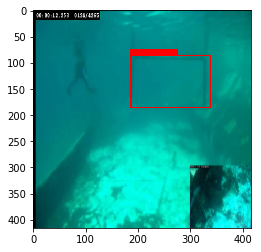

Found 5 boxes for image.
[[  98.1674118   107.74565125  130.07728577  130.17655945]
 [ 108.88220215  199.34864807  138.16703796  220.45707703]
 [ 218.62788391  151.97518921  265.27676392  212.66781616]
 [  54.55644226  284.39437866   90.16709137  303.98098755]
 [ 217.78939819   99.52752686  239.90875244  114.82456207]]
('yellow_buoy 1.00', (108, 98), (130, 130))
('red_buoy 0.81', (199, 109), (220, 138))
('path_marker 0.75', (152, 219), (213, 265))
('yellow_buoy 0.72', (284, 55), (304, 90))
('green_buoy 0.57', (100, 218), (115, 240))


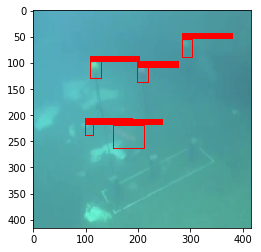

Found 3 boxes for image.
[[ 282.2598877    12.97644234  341.87969971   64.10053253]
 [ 205.61082458  220.25085449  263.11309814  265.81756592]
 [ 157.30731201    2.06545544  236.38464355   91.9260788 ]]
('red_buoy 1.00', (13, 282), (64, 342))
('green_buoy 0.99', (220, 206), (266, 263))
('channel 0.97', (2, 157), (92, 236))


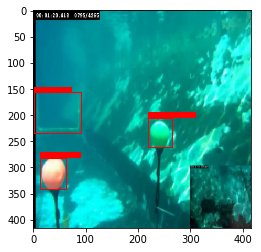

Found 1 boxes for image.
[[ 156.51023865  192.22068787  248.49472046  295.90475464]]
('start_gate 0.85', (192, 157), (296, 248))


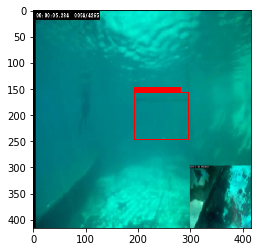

Found 5 boxes for image.
[[  98.1674118   107.74565125  130.07728577  130.17655945]
 [ 108.88220215  199.34864807  138.16703796  220.45707703]
 [ 218.62788391  151.97518921  265.27676392  212.66781616]
 [  54.55644226  284.39437866   90.16709137  303.98098755]
 [ 217.78939819   99.52752686  239.90875244  114.82456207]]
('yellow_buoy 1.00', (108, 98), (130, 130))
('red_buoy 0.81', (199, 109), (220, 138))
('path_marker 0.75', (152, 219), (213, 265))
('yellow_buoy 0.72', (284, 55), (304, 90))
('green_buoy 0.57', (100, 218), (115, 240))


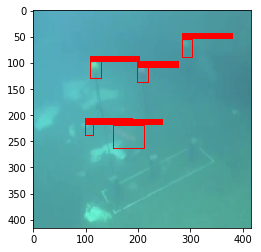

Found 1 boxes for image.
[[  22.01387024  186.0788269   443.20431519  428.96697998]]
('channel 0.78', (186, 22), (416, 416))


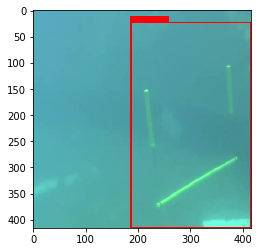

Found 6 boxes for image.
[[ 208.21601868  266.1078186   246.27468872  292.84909058]
 [ 173.70259094  106.75773621  236.38656616  180.39823914]
 [ 241.30345154  154.34141541  276.57772827  176.86257935]
 [ 339.5446167   146.9402771   391.05181885  161.75546265]
 [ 296.29110718  383.08081055  321.49206543  395.77310181]
 [ 274.40487671   24.90545654  306.04702759   44.71011353]]
('green_buoy 1.00', (266, 208), (293, 246))
('channel 0.99', (107, 174), (180, 236))
('red_buoy 0.98', (154, 241), (177, 277))
('path_marker 0.97', (147, 340), (162, 391))
('path_marker 0.86', (383, 296), (396, 321))
('yellow_buoy 0.77', (25, 274), (45, 306))


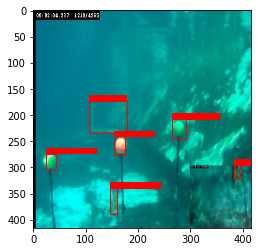

Found 1 boxes for image.
[[  21.94878197   22.19962692  332.36309814  339.26541138]]
('start_gate 0.98', (22, 22), (339, 332))


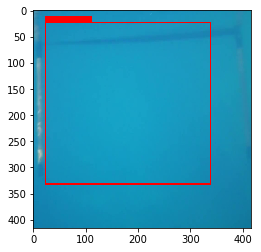

Found 3 boxes for image.
[[ 281.76647949   23.23970413  344.37799072   75.0732193 ]
 [ 210.62309265  226.14758301  265.09243774  271.69662476]
 [ 156.73147583    2.32749462  236.4928894    91.19342041]]
('red_buoy 1.00', (23, 282), (75, 344))
('green_buoy 0.99', (226, 211), (272, 265))
('channel 0.98', (2, 157), (91, 236))


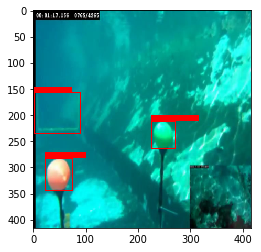

Found 1 boxes for image.
[[  16.40560532   41.8756752   337.70092773  380.3394165 ]]
('start_gate 0.98', (42, 16), (380, 338))


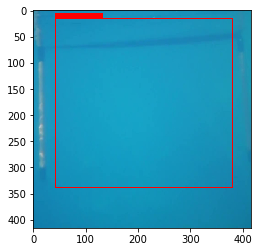

Found 1 boxes for image.
[[  38.05866241   42.50093079  361.91784668  377.98855591]]
('start_gate 0.95', (43, 38), (378, 362))


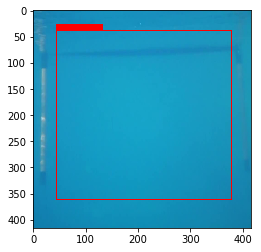

Found 2 boxes for image.
[[ 182.92593384  149.59661865  275.69564819  237.09217834]
 [ 351.6003418   137.25680542  418.92541504  154.56082153]]
('red_buoy 0.98', (150, 183), (237, 276))
('path_marker 0.93', (137, 352), (155, 416))


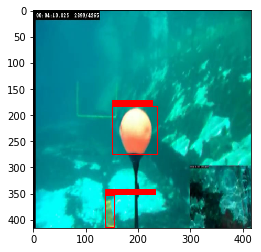

Found 0 boxes for image.
[]


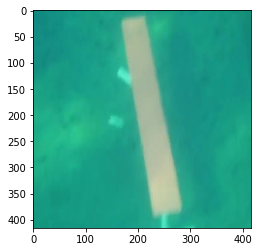

Found 3 boxes for image.
[[ 202.7925415   232.60137939  274.17861938  290.02093506]
 [ 139.91590881   -2.27090502  222.07263184  111.26203918]
 [ 290.58047485    7.19678688  372.33224487   21.53717232]]
('green_buoy 0.97', (233, 203), (290, 274))
('channel 0.93', (0, 140), (111, 222))
('red_buoy 0.92', (7, 291), (22, 372))


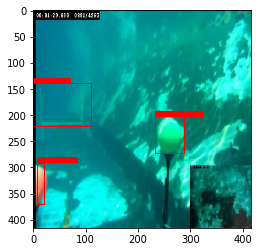

Found 1 boxes for image.
[[ 104.77952576  156.90708923  199.65830994  236.740448  ]]
('red_buoy 0.76', (157, 105), (237, 200))


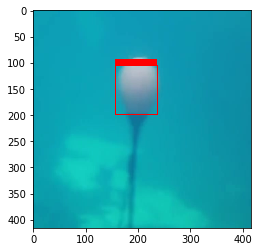

Found 1 boxes for image.
[[  34.95241547   40.91675568  332.0843811   381.4246521 ]]
('start_gate 0.96', (41, 35), (381, 332))


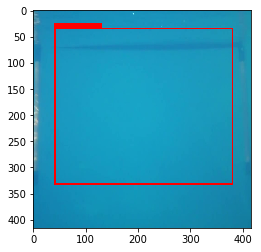

Found 5 boxes for image.
[[ 209.37982178  121.8000946   231.82691956  139.1885376 ]
 [ 176.40541077  221.33929443  213.0692749   242.17558289]
 [ 300.76400757  395.1373291   344.13562012  408.98883057]
 [ 223.07650757    6.38266277  254.51004028   14.45962429]
 [ 299.50146484  117.06925201  357.96862793  131.14805603]]
('red_buoy 0.99', (122, 209), (139, 232))
('green_buoy 0.98', (221, 176), (242, 213))
('path_marker 0.77', (395, 301), (409, 344))
('yellow_buoy 0.76', (6, 223), (14, 255))
('path_marker 0.73', (117, 300), (131, 358))


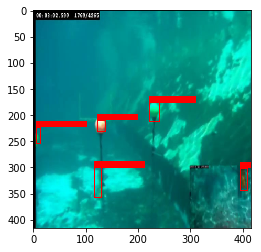

Found 2 boxes for image.
[[ 387.87493896  218.52326965  415.43780518  241.70307922]
 [ -26.72975731  144.79118347  356.3475647   409.82611084]]
('path_marker 0.98', (219, 388), (242, 415))
('channel 0.64', (145, 0), (410, 356))


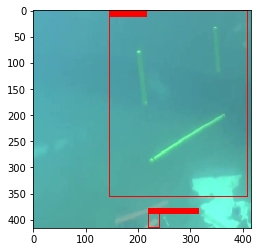

Found 1 boxes for image.
[[  26.41693687   41.62656403  334.3706665   384.97192383]]
('start_gate 0.97', (42, 26), (385, 334))


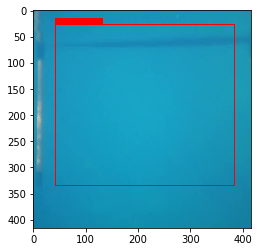

Found 4 boxes for image.
[[ 267.15029907  256.59677124  282.78598022  268.23019409]
 [ 255.39758301  306.33761597  271.11517334  320.05178833]
 [ 281.54449463  192.14059448  299.45513916  206.03347778]
 [ 192.66363525  171.45062256  245.33810425  227.29013062]]
('red_buoy 1.00', (257, 267), (268, 283))
('green_buoy 0.99', (306, 255), (320, 271))
('yellow_buoy 0.97', (192, 282), (206, 299))
('channel 0.64', (171, 193), (227, 245))


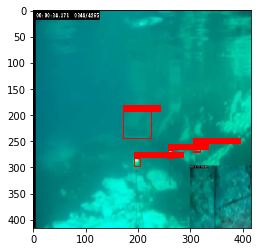

In [20]:
image_set='val' 
weights_name='trained_stage_3_best.h5'
save_all=False
draw(model_body,class_names,anchors,image_data,image_set=image_set,weights_name=weights_name,save_all=save_all)

(63, 1, 416, 416, 3)
Found 3 boxes for image.
[[ 160.02520752    2.27230597  239.98651123   98.52265167]
 [ 278.38751221   14.42776108  346.6918335    68.96567535]
 [ 224.02502441  229.32423401  263.56744385  254.14813232]]
('channel 1.00', (2, 160), (99, 240))
('red_buoy 0.95', (14, 278), (69, 347))
('green_buoy 0.87', (229, 224), (254, 264))


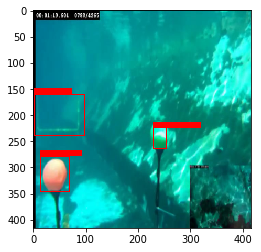

Found 2 boxes for image.
[[ 146.64253235    4.77581787  225.34889221   99.09297943]
 [ 118.93536377  234.62182617  251.98406982  323.31222534]]
('channel 0.98', (5, 147), (99, 225))
('yellow_buoy 0.89', (235, 119), (323, 252))


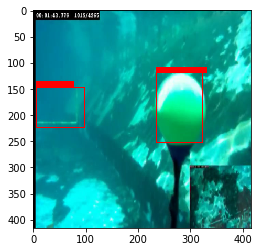

Found 0 boxes for image.
[]


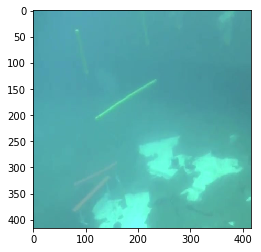

Found 2 boxes for image.
[[ 155.74330139   -0.5527699   235.8041687    92.69250488]
 [ 171.38934326  209.35626221  241.6315918   268.51776123]]
('channel 0.99', (0, 156), (93, 236))
('green_buoy 0.94', (209, 171), (269, 242))


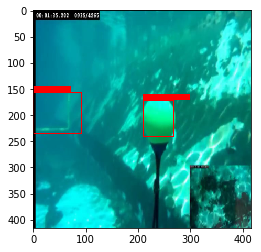

Found 1 boxes for image.
[[ 180.57263184   60.93610001  214.19007874   83.17845917]]
('green_buoy 0.98', (61, 181), (83, 214))


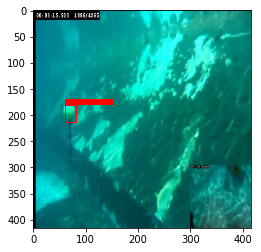

Found 3 boxes for image.
[[ 151.10992432   85.87924957  216.0824585   160.81541443]
 [ 179.15245056  267.40896606  212.84628296  290.41430664]
 [ 330.10369873  128.22790527  384.72341919  145.05078125]]
('channel 0.99', (86, 151), (161, 216))
('green_buoy 0.94', (267, 179), (290, 213))
('path_marker 0.85', (128, 330), (145, 385))


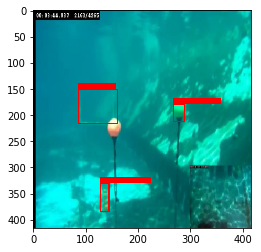

Found 1 boxes for image.
[[ 159.22338867  134.57202148  235.97515869  218.89884949]]
('channel 0.95', (135, 159), (219, 236))


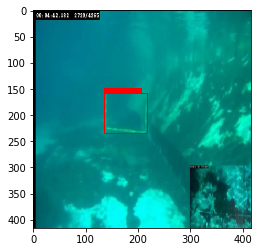

Found 3 boxes for image.
[[ 199.73014832  264.47372437  221.80783081  279.39816284]
 [ 198.70959473  296.36593628  220.18154907  311.46365356]
 [ 202.83045959  205.0065155   222.15718079  218.28329468]]
('red_buoy 0.95', (264, 200), (279, 222))
('green_buoy 0.93', (296, 199), (311, 220))
('yellow_buoy 0.74', (205, 203), (218, 222))


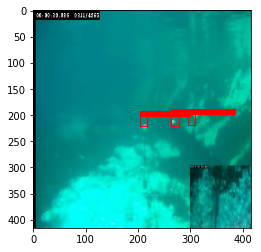

Found 4 boxes for image.
[[ 170.776474    271.23565674  185.9352417   282.83059692]
 [ 172.14146423  239.47842407  185.76376343  250.21261597]
 [ 170.73710632  303.29605103  186.31886292  314.68777466]
 [ 193.48728943  240.0881958   210.27957153  253.0475769 ]]
('red_buoy 0.68', (271, 171), (283, 186))
('yellow_buoy 0.65', (239, 172), (250, 186))
('green_buoy 0.64', (303, 171), (315, 186))
('yellow_buoy 0.58', (240, 193), (253, 210))


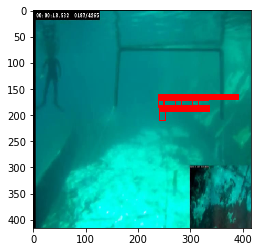

Found 0 boxes for image.
[]


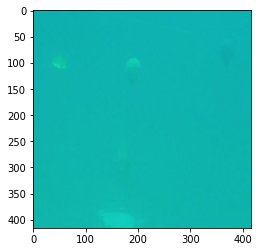

Found 0 boxes for image.
[]


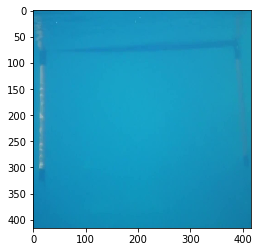

Found 2 boxes for image.
[[ 327.83728027  328.43148804  388.95666504  341.72946167]
 [ 121.15600586  175.08695984  242.79022217  310.73873901]]
('path_marker 0.91', (328, 328), (342, 389))
('channel 0.79', (175, 121), (311, 243))


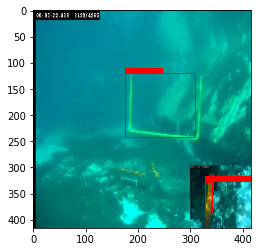

Found 0 boxes for image.
[]


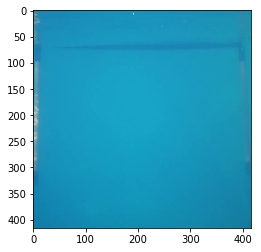

Found 1 boxes for image.
[[ 292.81063843  188.05740356  372.2230835   217.71539307]]
('path_marker 0.90', (188, 293), (218, 372))


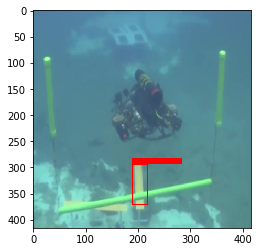

Found 3 boxes for image.
[[ 158.33340454    3.75197935  238.73686218  105.05569458]
 [ 264.93734741   10.7864933   335.50073242   63.24307632]
 [ 187.19023132  229.80383301  246.9994812   268.73068237]]
('channel 0.97', (4, 158), (105, 239))
('red_buoy 0.91', (11, 265), (63, 336))
('green_buoy 0.82', (230, 187), (269, 247))


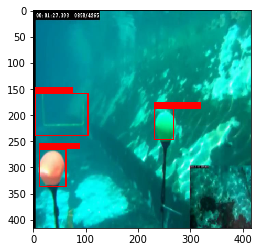

Found 0 boxes for image.
[]


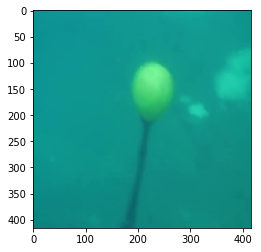

Found 0 boxes for image.
[]


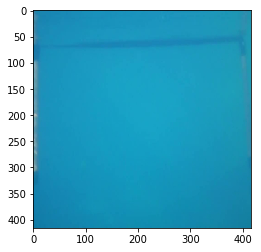

Found 0 boxes for image.
[]


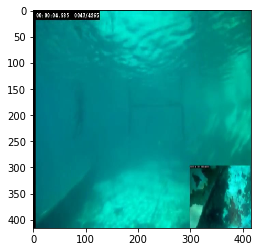

Found 4 boxes for image.
[[ 377.45214844  105.9418869   410.6769104   124.65480042]
 [ 151.6600647    38.8376236   221.05715942  111.85128021]
 [ 183.70280457  326.65713501  241.41529846  358.16238403]
 [ 252.32774353  159.84931946  331.3444519   214.38217163]]
('path_marker 0.92', (106, 377), (125, 411))
('channel 0.84', (39, 152), (112, 221))
('green_buoy 0.66', (327, 184), (358, 241))
('red_buoy 0.59', (160, 252), (214, 331))


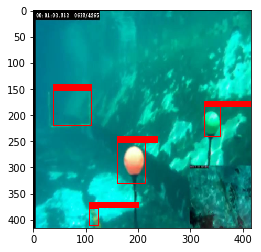

Found 5 boxes for image.
[[ 149.15139771  144.39115906  210.80117798  216.50823975]
 [ 184.11047363  292.69116211  214.47854614  313.89874268]
 [ 226.15049744   72.88513947  258.74502563   94.82325745]
 [ 304.43127441  393.98324585  349.01031494  409.01010132]
 [ 301.96673584  192.61367798  357.92202759  207.94113159]]
('channel 0.99', (144, 149), (217, 211))
('green_buoy 0.99', (293, 184), (314, 214))
('yellow_buoy 0.99', (73, 226), (95, 259))
('path_marker 0.93', (394, 304), (409, 349))
('path_marker 0.69', (193, 302), (208, 358))


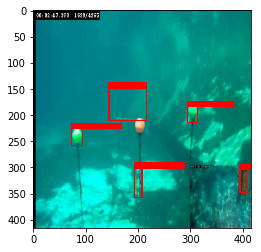

Found 0 boxes for image.
[]


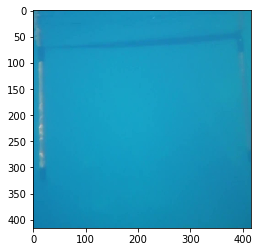

Found 5 boxes for image.
[[ 150.79463196  170.2197876   211.06864929  242.35855103]
 [ 185.00068665  321.80560303  216.22509766  343.41125488]
 [ 227.06744385  100.20758057  258.34384155  120.85203552]
 [ 308.05358887  393.65139771  355.42755127  407.93457031]
 [ 301.27636719  205.95077515  359.04519653  222.60017395]]
('channel 1.00', (170, 151), (242, 211))
('green_buoy 0.99', (322, 185), (343, 216))
('yellow_buoy 0.99', (100, 227), (121, 258))
('path_marker 0.95', (394, 308), (408, 355))
('path_marker 0.84', (206, 301), (223, 359))


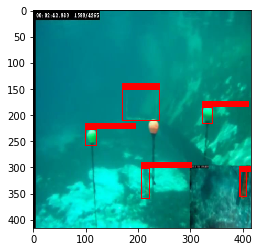

Found 5 boxes for image.
[[ 227.16615295  256.90765381  263.71212769  280.43780518]
 [ 165.24914551   99.7846756   231.95391846  178.3143158 ]
 [ 287.69024658    7.31941795  319.58633423   19.96300125]
 [ 264.16290283  139.61730957  296.21133423  159.07447815]
 [ 290.49490356  385.86209106  317.12329102  401.32427979]]
('green_buoy 0.99', (257, 227), (280, 264))
('channel 0.95', (100, 165), (178, 232))
('yellow_buoy 0.93', (7, 288), (20, 320))
('red_buoy 0.89', (140, 264), (159, 296))
('green_buoy 0.51', (386, 290), (401, 317))


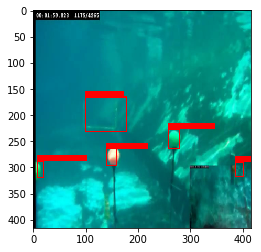

Found 0 boxes for image.
[]


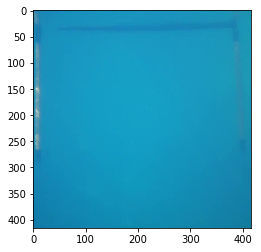

Found 3 boxes for image.
[[ 227.52966309  254.40359497  261.42645264  275.59213257]
 [ 265.12652588  128.40167236  297.64971924  147.13645935]
 [ 178.15982056   78.25434113  250.19500732  159.03411865]]
('green_buoy 0.97', (254, 228), (276, 261))
('red_buoy 0.97', (128, 265), (147, 298))
('channel 0.95', (78, 178), (159, 250))


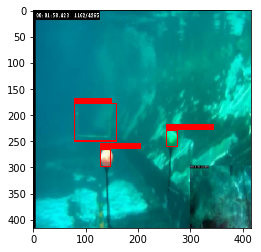

Found 5 boxes for image.
[[ 153.6244812   210.87413025  215.16261292  278.42752075]
 [ 227.16705322  141.46032715  259.20162964  163.20565796]
 [ 309.10910034  395.7144165   358.74777222  409.69580078]
 [ 187.28135681  366.91320801  222.11532593  390.46807861]
 [ 302.22885132  240.18278503  360.13446045  259.08773804]]
('channel 1.00', (211, 154), (278, 215))
('yellow_buoy 0.98', (141, 227), (163, 259))
('path_marker 0.96', (396, 309), (410, 359))
('green_buoy 0.92', (367, 187), (390, 222))
('path_marker 0.68', (240, 302), (259, 360))


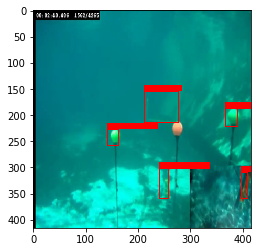

Found 0 boxes for image.
[]


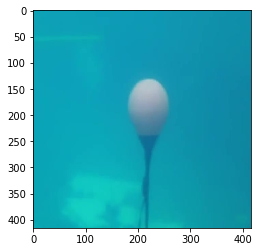

Found 4 boxes for image.
[[ 134.71768188  110.47123718  210.56929016  190.55734253]
 [ 379.30773926  160.44094849  414.32971191  178.13122559]
 [ 290.29602051  301.22601318  310.65493774  314.58868408]
 [ 292.04949951  327.77246094  313.82336426  343.46554565]]
('channel 0.99', (110, 135), (191, 211))
('path_marker 0.90', (160, 379), (178, 414))
('red_buoy 0.51', (301, 290), (315, 311))
('green_buoy 0.50', (328, 292), (343, 314))


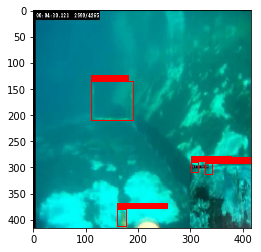

Found 1 boxes for image.
[[ 110.65458679  135.14971924  260.01611328  224.38497925]]
('yellow_buoy 0.89', (135, 111), (224, 260))


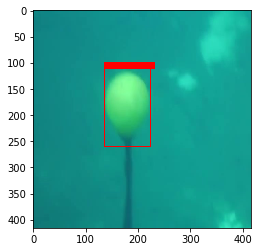

Found 3 boxes for image.
[[ 194.47370911  263.81719971  216.76345825  278.62606812]
 [ 195.76933289  295.04162598  217.45210266  310.20474243]
 [ 201.20896912  205.88551331  221.22370911  219.41256714]]
('red_buoy 0.96', (264, 194), (279, 217))
('green_buoy 0.90', (295, 196), (310, 217))
('yellow_buoy 0.89', (206, 201), (219, 221))


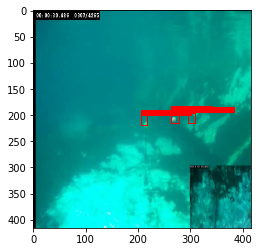

Found 4 boxes for image.
[[ 161.76011658    5.36999035  240.36697388  103.87931824]
 [ 260.58325195   11.90670967  332.55126953   64.25196838]
 [ 377.73468018   62.71576691  411.38082886   80.54446411]
 [ 187.86824036  228.6020813   247.76179504  266.03005981]]
('channel 0.99', (5, 162), (104, 240))
('red_buoy 0.86', (12, 261), (64, 333))
('path_marker 0.81', (63, 378), (81, 411))
('green_buoy 0.81', (229, 188), (266, 248))


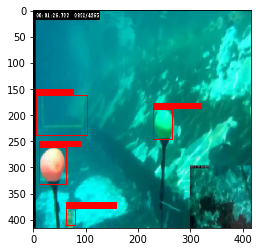

Found 1 boxes for image.
[[ 111.59658051  160.74087524  248.53953552  252.72372437]]
('yellow_buoy 0.71', (161, 112), (253, 249))


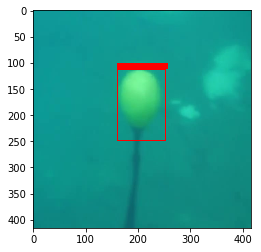

Found 2 boxes for image.
[[ 180.54501343  126.00670624  213.3822937   148.53294373]
 [ 149.16555786   -0.33471179  217.49049377   83.87336731]]
('green_buoy 0.99', (126, 181), (149, 213))
('channel 0.97', (0, 149), (84, 217))


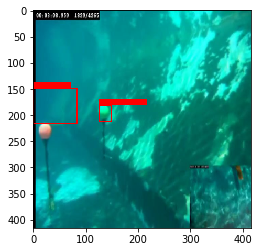

Found 2 boxes for image.
[[ 228.13104248  240.92604065  243.30943298  252.7212677 ]
 [ 202.79873657  303.38150024  218.19146729  314.70278931]]
('yellow_buoy 0.62', (241, 228), (253, 243))
('green_buoy 0.59', (303, 203), (315, 218))


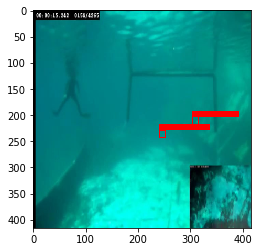

Found 2 boxes for image.
[[ 351.38070679   94.17217255  384.10626221  192.95925903]
 [ 277.28088379  194.48164368  346.30413818  224.73150635]]
('path_marker 0.92', (94, 351), (193, 384))
('path_marker 0.59', (194, 277), (225, 346))


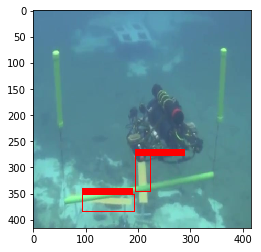

Found 4 boxes for image.
[[ 183.64910889  221.75216675  211.25079346  240.87255859]
 [ 159.03692627  289.81411743  189.32427979  309.37213135]
 [ 140.83601379  101.98160553  197.8765564   175.48414612]
 [ 210.08929443  124.45835876  242.78170776  143.16941833]]
('red_buoy 0.95', (222, 184), (241, 211))
('green_buoy 0.94', (290, 159), (309, 189))
('channel 0.92', (102, 141), (175, 198))
('yellow_buoy 0.89', (124, 210), (143, 243))


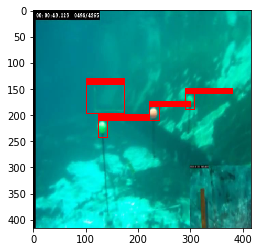

Found 0 boxes for image.
[]


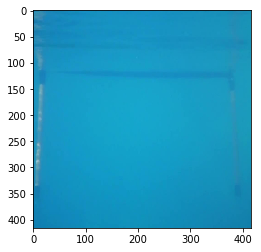

Found 3 boxes for image.
[[ 160.76641846    3.97953415  239.91497803   94.55725098]
 [ 274.51831055   50.66420364  344.13217163  103.83200073]
 [ 218.59597778  253.11328125  261.21789551  277.19824219]]
('channel 0.99', (4, 161), (95, 240))
('red_buoy 0.95', (51, 275), (104, 344))
('green_buoy 0.78', (253, 219), (277, 261))


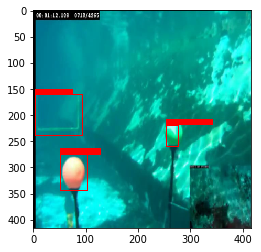

Found 4 boxes for image.
[[ 215.09104919  198.00419617  243.84399414  219.37844849]
 [ 232.02793884   92.40584564  263.6668396   113.64028168]
 [ 198.12414551  297.07086182  226.49206543  318.49118042]
 [ 309.88955688  388.06652832  351.05718994  403.0090332 ]]
('red_buoy 0.99', (198, 215), (219, 244))
('yellow_buoy 0.99', (92, 232), (114, 264))
('green_buoy 0.98', (297, 198), (318, 226))
('path_marker 0.93', (388, 310), (403, 351))


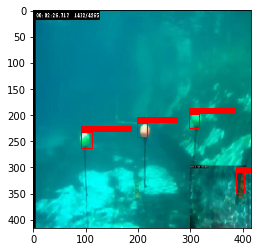

Found 3 boxes for image.
[[ 156.30361938  295.4538269   216.07901001  367.13482666]
 [ 228.73583984  234.18225098  257.48461914  253.92811584]
 [ 326.63665771  388.72207642  387.1010437   402.42520142]]
('channel 0.98', (295, 156), (367, 216))
('yellow_buoy 0.98', (234, 229), (254, 257))
('path_marker 0.97', (389, 327), (402, 387))


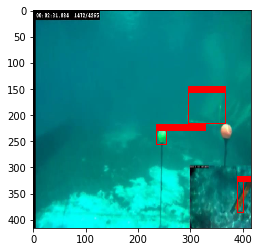

Found 3 boxes for image.
[[  1.60575287e+02   1.27399445e-01   2.39205002e+02   9.59521561e+01]
 [  2.72100677e+02   1.12615913e+02   3.43025879e+02   1.64476074e+02]
 [  2.11145386e+02   2.96773102e+02   2.55548676e+02   3.22698517e+02]]
('channel 0.99', (0, 161), (96, 239))
('red_buoy 0.96', (113, 272), (164, 343))
('green_buoy 0.72', (297, 211), (323, 256))


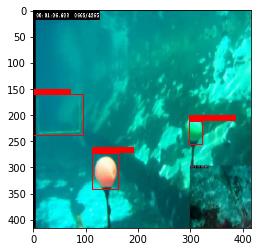

Found 3 boxes for image.
[[ 150.33183289    7.20193672  220.84884644   95.92958069]
 [ 179.35708618  157.71833801  212.99920654  179.74421692]
 [ 294.49664307  385.76403809  326.24035645  401.71505737]]
('channel 1.00', (7, 150), (96, 221))
('green_buoy 0.98', (158, 179), (180, 213))
('path_marker 0.83', (386, 294), (402, 326))


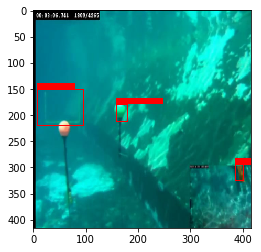

Found 4 boxes for image.
[[ 170.37480164  271.30947876  185.67567444  282.98397827]
 [ 171.85720825  239.44215393  185.59411621  250.24388123]
 [ 170.50286865  303.31112671  186.2752533   314.80917358]
 [ 193.15075684  240.02900696  210.42651367  253.26272583]]
('red_buoy 0.70', (271, 170), (283, 186))
('yellow_buoy 0.65', (239, 172), (250, 186))
('green_buoy 0.63', (303, 171), (315, 186))
('yellow_buoy 0.57', (240, 193), (253, 210))


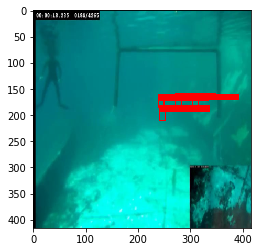

Found 1 boxes for image.
[[ 168.61894226  271.18685913  183.05316162  282.18432617]]
('yellow_buoy 0.51', (271, 169), (282, 183))


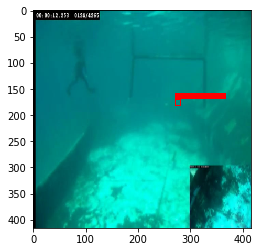

Found 0 boxes for image.
[]


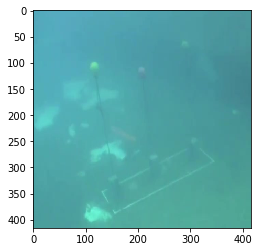

Found 3 boxes for image.
[[ 159.26687622    1.48225212  239.74017334  101.40164185]
 [ 277.72192383   14.09244156  345.30725098   68.14157104]
 [ 207.70852661  219.77307129  268.50500488  259.3085022 ]]
('channel 0.99', (1, 159), (101, 240))
('red_buoy 0.93', (14, 278), (68, 345))
('green_buoy 0.90', (220, 208), (259, 269))


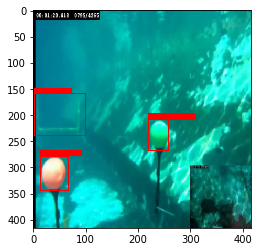

Found 0 boxes for image.
[]


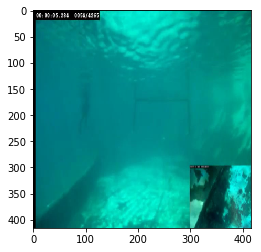

Found 0 boxes for image.
[]


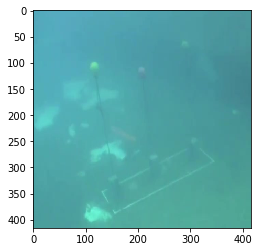

Found 0 boxes for image.
[]


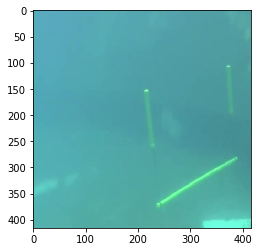

Found 5 boxes for image.
[[ 174.80708313  107.53379822  238.73249817  183.60394287]
 [ 213.67004395  263.19241333  246.4473114   286.0930481 ]
 [ 241.76254272  156.07170105  274.58486938  177.10539246]
 [ 336.0458374   143.67893982  395.30023193  162.45109558]
 [ 265.36422729   11.92883492  298.17514038   34.74612045]]
('channel 1.00', (108, 175), (184, 239))
('green_buoy 0.98', (263, 214), (286, 246))
('red_buoy 0.95', (156, 242), (177, 275))
('path_marker 0.80', (144, 336), (162, 395))
('yellow_buoy 0.74', (12, 265), (35, 298))


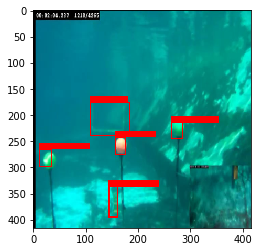

Found 0 boxes for image.
[]


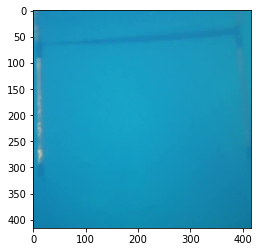

Found 3 boxes for image.
[[ 159.6809845     2.20748425  239.64859009   99.01680756]
 [ 274.60955811   23.45136261  347.11358643   75.78868103]
 [ 211.91159058  228.00076294  269.61212158  265.92599487]]
('channel 0.99', (2, 160), (99, 240))
('red_buoy 0.93', (23, 275), (76, 347))
('green_buoy 0.93', (228, 212), (266, 270))


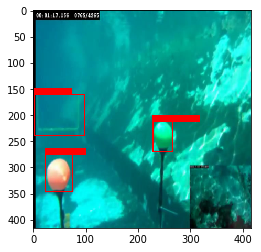

Found 0 boxes for image.
[]


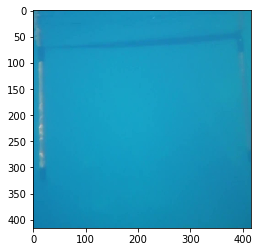

Found 0 boxes for image.
[]


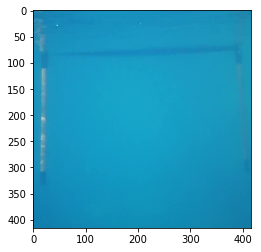

Found 3 boxes for image.
[[ 131.83105469   78.07266235  207.98373413  160.44650269]
 [ 189.18771362  171.06965637  278.65887451  225.36860657]
 [ 348.27560425  135.61149597  407.42907715  154.35873413]]
('channel 0.99', (78, 132), (160, 208))
('red_buoy 0.79', (171, 189), (225, 279))
('path_marker 0.78', (136, 348), (154, 407))


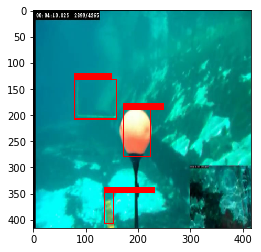

Found 2 boxes for image.
[[ 253.85710144  206.92192078  430.0513916   289.36221313]
 [  56.70319366  166.80322266  236.42147827  259.51525879]]
('path_marker 0.75', (207, 254), (289, 416))
('path_marker 0.59', (167, 57), (260, 236))


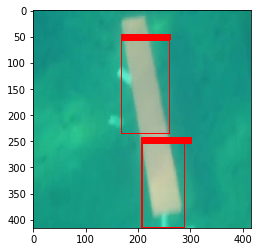

Found 2 boxes for image.
[[ 143.97741699    7.11917543  223.96105957  103.28107452]
 [ 204.6678772   237.86576843  272.72259521  283.98587036]]
('channel 0.94', (7, 144), (103, 224))
('green_buoy 0.88', (238, 205), (284, 273))


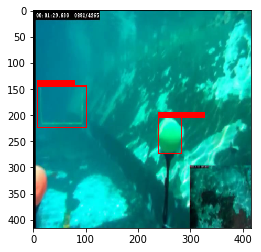

Found 1 boxes for image.
[[  91.11985016  155.45600891  203.14172363  248.96720886]]
('red_buoy 0.66', (155, 91), (249, 203))


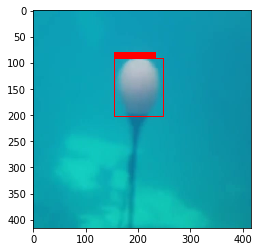

Found 0 boxes for image.
[]


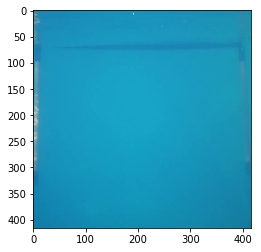

Found 4 boxes for image.
[[ 148.77937317   79.02946472  214.74981689  154.62652588]
 [ 180.74752808  222.42544556  213.45042419  243.73353577]
 [ 300.20339966  391.53085327  334.37338257  406.4045105 ]
 [ 305.18304443  128.29588318  357.77331543  144.01939392]]
('channel 1.00', (79, 149), (155, 215))
('green_buoy 0.99', (222, 181), (244, 213))
('path_marker 0.84', (392, 300), (406, 334))
('path_marker 0.61', (128, 305), (144, 358))


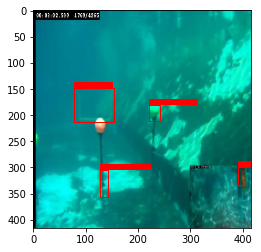

Found 0 boxes for image.
[]


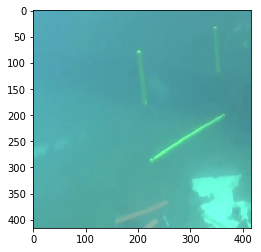

Found 0 boxes for image.
[]


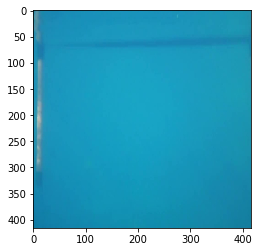

Found 4 boxes for image.
[[ 259.96331787  257.88522339  285.19830322  274.39929199]
 [ 258.63571167  296.715271    281.72302246  312.75302124]
 [ 201.25260925  172.20576477  258.13470459  236.26182556]
 [ 278.94393921  194.95857239  306.18746948  210.38485718]]
('red_buoy 0.98', (258, 260), (274, 285))
('green_buoy 0.92', (297, 259), (313, 282))
('channel 0.83', (172, 201), (236, 258))
('yellow_buoy 0.82', (195, 279), (210, 306))


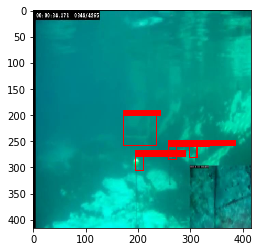

In [21]:
image_set='val' 
weights_name='trained_stage_3.h5'
save_all=False
draw(model_body,class_names,anchors,image_data,image_set=image_set,weights_name=weights_name,save_all=save_all)